In [1]:
import numpy as np
import torch
import torch.nn as nn
import math

import matplotlib.pyplot as plt
%matplotlib inline

### Model

We will consider simple Bayesian Super-Resolution Image Model. From technical side it is very similiar with RVM Regression (and they both have same author Michael E. Tipping).

In general setting, what is going on:

1. We are given K low-resolution images $y_k$ of one image high-resolution $x$
2. We consider some linear degradation model for each image $W_k$
3. Maximise Evidence of the model with respect to parameters
4. Obtain high-resolution image estimator $x$


For the image: 

$$ 
Img \in\mathbb R^{N\times M} = \begin{bmatrix}
p_1 & \dots  &  p_N \\ 
p_{N+1} & \dots  & p_{2N} \\ 
\dots & \dots & \dots \\
p_{N+M} & \dots & p_{NM}  
\end{bmatrix}
$$

We will consider following representations.

Intensity vector:

$$
y = \begin{bmatrix}
& p_1 \\
& \vdots \\
& \vdots\\
& \vdots \\
& p_{NM}
\end{bmatrix}
$$


2D-Spatial coordinates of the each pixel:

$$
V = \begin{bmatrix}
v_1 \\
\vdots \\
\vdots\\
\vdots \\
v_{NM}
\end{bmatrix} = \begin{bmatrix}
1 & 1 \\
1 & 2  \\
\vdots & \vdots\\
\vdots & \vdots \\
N & M
\end{bmatrix}
$$



<img src="img/img2spatial.jpg" width="600">

We consider low-resolution observed images $y^k\in\mathbb{R^M}$ and high-resolution unobserved $x\in\mathbb{R^N}$, $N>M$

#### Prior

$$
p(x) = \mathcal{N}(x|0, Z_{x}) \\
Z_x(p_i, p_j) = A\exp\left(- \dfrac{\|v_i - v_j\|^2_2}{r^2}\right)
$$

Where $v_i, v_j$ denotes the 2D-spatial postions of the pixels $i$ and $j$.
Matrix $Z_x$ is fixed and we will use $A=1, r = 2$ 

#### Distortion model

From original (unobserved) image $x$ we obtain observed $y$ by corraption with the distortion matrix $W^k\in\mathbb{R}^{M\times N}$

$$
y^{k} = W^{k}x+{\varepsilon}_k \\
\varepsilon_k^{i}\sim_{\text{iid}}\mathcal{N}(0,\beta^{-1})
$$

Matrix $W_k$ is maden by function which captures the down-sampling process.

$$
W_{ji}^{k} = \dfrac{\widetilde{W}_{ji}^{k}}{\sum_{i'}\widetilde{W}^{k}_{ji}}
$$

$$
\widetilde{W}_{ij}^{k} = \exp\left(\dfrac{\|v_i - u_{j}^{k}\|_2^2}{\gamma^2}\right)
$$

As $W_k\in\mathbb{R}^{M\times N}$, $j=1,\dots,M$ and $i=1,\dots,N$

$v_i$ is the spatial coordinates of $i$ pixel of the orignal image $x$. And $u_j$ is made by rotation and shift:

$$
u_j^{k} = R^{k}(v_j - \overline{v})+\overline{v} + s_k
$$

Where $R^{k}$ is the rotation matrix of $k$ image:

$$
R^{k} = \begin{pmatrix}
\cos\theta_k & \sin\theta_k\\ 
-\sin\theta_k &  \cos\theta_k
\end{pmatrix}
$$
And $s_k$ is shift of image

### Likelihood

For now, we can write the likelihood function:
    
$$
p(y^{k}|x,s_k,\theta_k,\gamma) = \left(\dfrac{\beta}{2\pi}\right)^{M/2}\exp\left(-\dfrac{\beta}{2}\|y^{k} - W^{k}x\|^2_2\right)
$$

With this result, if we know $\{y^k, s_k, \theta_k\}_{k=1}^{K},\gamma$, we can restore $x$ just with MAP estimation $\mu$

### Posterior

$$ p(x|\{y^k, s_k, \theta_k\}_{k=1}^{K},\gamma)
= \frac
{\prod_{k=1}^K p(y^{k}|x,s_k,\theta_k,\gamma) p(x)}
{\int \prod_{k=1}^K p(y^{k}|x,s_k,\theta_k,\gamma) p(x) dx} \propto $$

$$ \propto \prod_{k=1}^K 
\exp\left(-\dfrac{\beta}{2}\|y^{k} - W^{k}x\|^2_2\right)
\exp\left(-\dfrac{1}{2} x^T Z_{x}^{-1} x \right) = $$

$$ = \exp \left( 
-\dfrac{\beta}{2} \sum_{k=1}^K (y^{k} - W^{k}x)^T (y^{k} - W^{k}x)-\dfrac{1}{2} x^T Z_{x}^{-1} x 
\right) = $$


$$ = \exp \bigg\{
-\dfrac{1}{2} \left(
\beta \sum_{k=1}^K {y^k}^Ty^{k} 
- 2 \beta \sum_{k=1}^K {y^k}^T W^{k}x 
+ \beta \sum_{k=1}^K x^T {W^{k}}^T W^{k}x + x^T Z_{x}^{-1} x 
\right)
\bigg\} = $$

$$ = \exp \bigg\{
-\dfrac{1}{2} \left(
\beta \sum_{k=1}^K {y^k}^Ty^{k} 
- 2 \beta \sum_{k=1}^K {y^k}^T W^{k}x 
+ x^T \left[ Z_{x}^{-1} + \beta \sum_{k=1}^K {W^{k}}^T W^{k} \right] x 
\right)
\bigg\} $$

Let us denote:

$$ M = Z_{x}^{-1} + \beta \sum_{k=1}^K {W^{k}}^T W^{k} $$

$$ m = \beta (M^{-1})^T \left( \sum_{k=1}^K {y^k}^T W^{k} \right) $$

Then our expression transforms into:

$$ \exp \left\{ -\dfrac{1}{2} \left( x^T M x - 2 m^T M x + const \right) \right\} 
\propto \exp \left\{ -\dfrac{1}{2} (x-m)^T M (x-m) \right\}  $$

Hence,

$$ p(x|\{y^k, s_k, \theta_k\}_{k=1}^{K},\gamma) = \mathcal{N}(\mu, \Sigma) $$

$$ \Sigma = \left[ Z_x^{-1} + \beta \sum_{k=1}^K {W^k}^T {W^k} \right]^{-1} $$

$$ \mu = \beta \Sigma \left( \sum_{k=1}^K {W^k}^T y^k \right) $$

### Evidence

$$ p(y_1,\dots,y_k;\{s_k, \theta_k\}_{k=1}^{K},\gamma) 
= \int \prod_{k=1}^K p(y^{k}|x,s_k,\theta_k,\gamma) p(x) dx = $$

$$ = \frac{\beta^{\frac{KM}{2}}}{(2\pi)^{\frac{KM + N}{2}}\left|Z_x\right|^{\frac{1}{2}}} 
\exp \bigg\{
-\dfrac{1}{2} \left(
\beta \sum_{k=1}^K {y^k}^Ty^{k} 
- 2 \beta \sum_{k=1}^K {y^k}^T W^{k}x 
+ x^T \left[ Z_{x}^{-1} + \beta \sum_{k=1}^K {W^{k}}^T W^{k} \right] x 
\right)
\bigg\} = $$

$$ = \frac{\beta^{\frac{KM}{2}}}{(2\pi)^{\frac{KM + N}{2}}\left|Z_x\right|^{\frac{1}{2}}} 
\int
\exp \bigg\{
-\dfrac{1}{2} \left(
\beta \sum_{k=1}^K {y^k}^Ty^{k} 
- 2 \mu^T \Sigma^{-1} x 
+ x^T \Sigma^{-1} x
+ \mu^T \Sigma^{-1} \mu
- \mu^T \Sigma^{-1} \mu
\right)
\bigg\} dx = $$

$$ = \frac{\beta^{\frac{KM}{2}}}{(2\pi)^{\frac{KM + N}{2}}\left|Z_x\right|^{\frac{1}{2}}} 
\exp \bigg\{
-\dfrac{\beta}{2}
\sum_{k=1}^K {y^k}^Ty^{k} 
+ \dfrac{1}{2} \mu^T \Sigma^{-1} \mu
\bigg\}
\int
\exp \bigg\{
-\dfrac{1}{2}
(x-\mu)^T \Sigma^{-1} (x-\mu)
\bigg\} dx $$

One can notice that:

$$ \int
\exp \bigg\{
-\dfrac{1}{2}
(x-\mu)^T \Sigma^{-1} (x-\mu)
\bigg\} dx = 
(2\pi)^{\frac{N}{2}} \left| \Sigma \right|^{\frac{1}{2}} $$

Finally,

$$ p(y_1,\dots,y_k;\{s_k, \theta_k\}_{k=1}^{K},\gamma)
= \frac{\beta^{\frac{KM}{2}}  \left| \Sigma \right|^{\frac{1}{2}} }
{(2\pi)^{\frac{KM}{2}}\left|Z_x\right|^{\frac{1}{2}}} 
\exp \bigg\{
-\dfrac{\beta}{2}
\sum_{k=1}^K {y^k}^Ty^{k} 
+ \dfrac{1}{2} \mu^T \Sigma^{-1} \mu
\bigg\} $$

### Coding

For now, you should optimise over $\left(\{s_k,\theta_k\}_{k=1}^{K},\gamma\right)$ log of evidence:

$$
\max \log p(y_1,\dots,y_k;\{s_k, \theta_k\}_{k=1}^{K},\gamma)
$$

And then just use $\mu$ as estimator of original image. 

For Michael E. Tipping it was hard problem, I guess.

But you are have PyTorch! So, just write forward pass, use minus log of evidence as loss function and Adam as optimizer.

Before that, we need to generate train dataset of corrupted images.
You can use my image or any image that you like! But note that we have $K$ matrix of $N\times M$, so to make all faster, it is better to take small images. 

In [2]:
def make_coordinates(h, w):
    x_1 = np.arange(h*w) % w
    x_2 = np.arange(h*w) // w    
    v = np.array([x_1, x_2]).T
    return v

In [3]:
X = plt.imread('img/duck30.png')[:,:,0]
X = (X - np.mean(X)) / np.std(X)

In [4]:
from scipy.misc import imresize
from scipy.ndimage import rotate

def make_train(img, rate=30, K=20, std=0.01, verbose=True):
    corrapted_ls = []
    theta_ls = [6, 5, -4, -7]
    for k in range(K):
        theta = np.random.choice(theta_ls)
        corrapted_img = rotate(img, theta)
        corrapted_img = imresize(corrapted_img, rate)
        corrapted_img = (corrapted_img - np.mean(corrapted_img)) / np.std(corrapted_img)
        noise = np.random.randn(corrapted_img.shape[0]*corrapted_img.shape[1])*std
        corrapted_img += noise.reshape(*corrapted_img.shape)
        corrapted_ls.append(corrapted_img)
        
    if verbose:
        fig = plt.figure(figsize=(20, 10));
        fig.subplots_adjust(hspace=0.4, wspace=0.4);
        for i in range(1, K+1):
            ax = fig.add_subplot(4, K // 4, i);
            ax.imshow(corrapted_ls[i-1], cmap='gray');
            
    return corrapted_ls

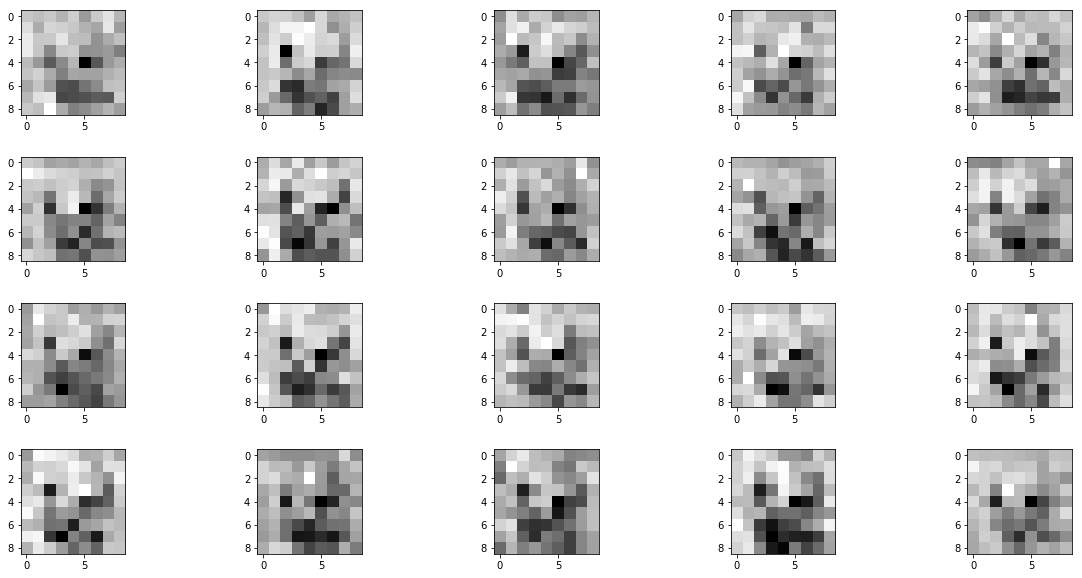

In [5]:
std = 0.5
img_corrapted = make_train(X, rate=30, K=20, std=std)
y = [img.flatten() for img in img_corrapted]

### log-evidence
$$ -\log p(y_1,\dots,y_k;\{s_k, \theta_k\}_{k=1}^{K},\gamma)
= 
- \log \left| \Sigma \right|
+ \log \left|Z_x\right|
+ \beta \sum_{k=1}^K {y^k}^Ty^{k} 
- \mu^T \Sigma^{-1} \mu $$

In [6]:
beta = 1/std
K = 20
N = X.shape[0]*X.shape[1]
M = y[0].shape[0]
r = 2

print(f"beta={beta}\nK={K}\nN={N}\nstd={std}\nr={r}")

beta=2.0
K=20
N=900
std=0.5
r=2


In [7]:
class Model(nn.Module):
    
    def __init__(self, X, K=20, std=0.5):
        super(Model, self).__init__()
        self.s = nn.Parameter(torch.randn(K, 2))
        self.theta = nn.Parameter(torch.randn(K))
        self.gamma = nn.Parameter(torch.tensor(1, dtype=torch.float, requires_grad=True))

        self.beta = 1./std
        self.N = X.shape[0]*X.shape[1]
        self.M = y[0].shape[0]
        self.K = K
        
        nu = self.get_nu(X)
        u = self.get_u(nu)
        self.Zx = self.get_zx(nu)
        self.W = self.get_w(nu, u)
        self.Sigma = self.get_sigma()        

    def forward(self, y):
        mu = self.get_mu(y)
        y_sum = sum(y[k].dot(y[k]) for k in range(K))
        detZx = torch.slogdet(self.Zx)[1]
        detSigma = torch.slogdet(self.Sigma)[1]
        return -detSigma + detZx + self.beta * y_sum - mu.dot(torch.mv(self.Sigma.inverse(), mu))
    
    def get_nu(self, X): # Nx2 vector
        return torch.Tensor(make_coordinates(*X.shape))
    
    def get_u(self, nu): # KxNx2
        u = torch.zeros(self.K, self.N, 2, dtype=torch.float)
        for k in range(self.K):
            theta_k = self.theta[k]
            R = torch.Tensor([[torch.cos(theta_k), torch.sin(theta_k)], [-torch.sin(theta_k), torch.cos(theta_k)]])
            nu_mean = nu.mean()
            u[k] = (nu - nu_mean).mm(R.t()) + nu_mean + self.s[k]
        return u
    
    def get_zx(self, nu): # NxN matrix
        nu_ = nu.reshape(1, *nu.shape)
        A_ = nu_.permute((1, 0, 2)) - nu_
        return A_.pow_(2).sum(dim=2).sqrt_().mul_(-0.25).exp_()
    
    def get_w(self, nu, u): # KxMxN
        W0 = self.get_w0(nu, u)
        W = torch.zeros(self.K, self.M, self.N)
        for k in range(self.K):
            W[k] = W0[k] / W0[k].sum(dim=0)
        return W
    
    def get_w0(self, nu, u): # KxMxN
        W0 = torch.zeros(self.K, self.M, self.N)
        for k in range(self.K):
            nu_ = nu.reshape(1, *nu.shape)
            A_ = nu_.permute((1, 0, 2)) - u[k]
            W0[k] = A_[:M,:].pow_(2).sum(dim=2).sqrt_().div(self.gamma**2).exp_()
        return W0
    
    def get_sigma(self): # NxN
        w_product = torch.zeros(self.N,self.N)
        for k in range(self.K):
            w_product += self.W[k].t().mm(self.W[k])
        return torch.inverse(self.Zx.inverse() + self.beta * w_product)
    
    def get_mu(self, y): # N
        wy_product = torch.zeros(self.N)
        for k in range(self.K):
            wy_product += torch.mv(self.W[k].t(), y[k])
        return self.beta * torch.mv(self.Sigma, wy_product)

In [8]:
model = Model(X)
optimizer = torch.optim.Adam(model.parameters())

In [9]:
for i in range(5):
    optimizer.zero_grad()
    y = torch.Tensor([img.flatten() for img in make_train(X, std=std, verbose=False)])
    loss = model(y)
    print(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()

3967.184814453125
3945.4267578125
3959.719970703125
3944.950927734375
3971.20166015625
